In [13]:
import requests
import pandas as pd
from io import StringIO

url = "https://digitallibrary.un.org/record/4060887/files/2025_7_23_ga_voting.csv?ln=en"

response = requests.get(url)


In [2]:
import os
import pandas as pd

# TODO: add vetoes, vetoes are not included atm
def fetch_UN_data(dir_path=None):
    """
    Fetches and processes United Nations General Assembly and Security Council voting data.
    
    This function retrieves voting data from either local files or the UN Digital Library,
    and transforms the data into two formats: original and pivoted (transformed).
    
    Parameters:
    -----------
    dir_path : str, optional
        Path to directory where data should be read from or saved to.
        If None, data will be fetched from the UN Digital Library and not saved locally.
    
    Returns:
    --------
    tuple
        A tuple containing four DataFrames:
        - df_ga: Original GA voting data
        - df_ga_transformed: Pivoted GA voting data with countries as columns
        - df_sc: Original SC voting data
        - df_sc_transformed: Pivoted SC voting data with countries as columns
    
    Notes:
    ------
    - Currently, the Security Council data does not include veto information explicitly.
    """

    df_ga = None
    df_sc = None

    if dir_path:
        try:
            df_ga = pd.read_csv(f"{dir_path}/2025_7_23_ga_voting.csv")
            df_sc = pd.read_csv(f"{dir_path}/2025_7_21_sc_voting.csv")
        except FileNotFoundError:
            print("Not all data found locally. Fetching from UN Digital Library...")
    if df_ga is None or df_sc is None:
        ga_url = "https://digitallibrary.un.org/record/4060887/files/2025_7_23_ga_voting.csv?ln=en"
        sc_url = "https://digitallibrary.un.org/record/4055387/files/2025_7_21_sc_voting.csv?ln=en"

        try:
            df_ga = pd.read_csv(ga_url)
            df_sc = pd.read_csv(sc_url)

            # Save data locally if dir_path is provided
            if dir_path:
                # Check if directory exists, create it if it doesn't
                if not os.path.exists(dir_path):
                    os.makedirs(dir_path)
                    print(f"Created directory: {dir_path}")
                
                df_ga.to_csv(f"{dir_path}/2025_7_23_ga_voting.csv", index=False)
                df_sc.to_csv(f"{dir_path}/2025_7_21_sc_voting.csv", index=False)
        except Exception as e:
            print("Error fetching data from UN Digital Library. The dataset might has been updated. Check the date in the URL.")
            print(f"Error: {e}")
            return None, None, None, None
    
    # Transform ga data
    ga_index_columns = ["undl_id", "date", "session", "resolution", "draft", "committee_report", "meeting", "title", "agenda_title", "subjects", "total_yes", "total_no", "total_abstentions", "total_non_voting", "total_ms", "undl_link"]
    df_ga_transformed = df_ga.pivot(index=ga_index_columns, columns='ms_code', values='ms_vote').reset_index()
    df_ga_transformed.columns.name = None

    # Transform sc data
    sc_index_columns = ["undl_id", "date", "resolution", "draft", "meeting", "description", "agenda", "subjects", "modality", "total_yes", "total_no", "total_abstentions", "total_non_voting", "total_ms", "undl_link"]
    df_sc_transformed = df_sc.pivot(index=sc_index_columns, columns='ms_code', values='ms_vote').reset_index()
    df_sc_transformed.columns.name = None

    return df_ga, df_ga_transformed, df_sc, df_sc_transformed


In [3]:
df_ga, df_ga_transformed, df_sc, df_sc_transformed = fetch_UN_data(dir_path="C:\\Users\\janic\\OneDrive\\Desktop\\ETH\\UN Projekt\\data")

C:\Users\janic\AppData\Local\Temp\ipykernel_13600\1467307482.py:37: DtypeWarning: Columns (5,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ga = pd.read_csv(f"{dir_path}/2025_7_23_ga_voting.csv")


In [ ]:
df_ga.columns.tolist()

# Display unique country codes and names

We want to check if there are country codes that map to multiple country names

In [ ]:
len(df_ga['ms_code'].unique())

In [ ]:
len(df_ga['ms_name'].unique())

In [ ]:
# Group by ms_code and collect all unique names associated with each code
ms_code_to_names = df_ga.groupby('ms_code')['ms_name'].unique().reset_index()

# Display number of codes with multiple names
multiple_names_mask = ms_code_to_names['ms_name'].apply(len) > 1
multiple_names_count = multiple_names_mask.sum()

print(f"Total unique country codes: {len(ms_code_to_names)}")
print(f"Country codes with multiple names: {multiple_names_count}")

# Display codes with multiple names
if multiple_names_count > 0:
    print("\nCountry codes with multiple associated names:")
    for _, row in ms_code_to_names[multiple_names_mask].iterrows():
        print(f"{row['ms_code']}: {', '.join(row['ms_name'])}")

In [ ]:
# Create a DataFrame with country codes and names
country_mapping = []
for _, row in ms_code_to_names.iterrows():
    code = row['ms_code']
    names = row['ms_name']
    # If it's a list with one element, just take that element
    if len(names) == 1:
        country_mapping.append({'Code': code, 'Name': names[0]})
    else:
        # For multiple names, join them with ' / '
        country_mapping.append({'Code': code, 'Name': ' / '.join(names)})

# Convert to DataFrame and display
country_df = pd.DataFrame(country_mapping)
country_df = country_df.sort_values('Code')

# Display with nice formatting
print(f"Total countries: {len(country_df)}\n")
for i, row in country_df.iterrows():
    print(f"{row['Code']}: {row['Name']}")

33 Countries have multiple names for the same country code. 

However one example that I noticed is that Yugoslavia (YUG) and Russian Federation (RUS) have separate country codes!

# Moving average of votes over time

So the idea here is to specify a time range that should be used for the moving average (say 6 months) and then for two specified countries (say USA and China) plot the moving average of agreement between these two countriess over time. Agreement for a vote $v$ is defined as:

$$
S_{v} = 1 - \frac{|V_{A,v} - V_{B,v}|}{2}
$$

We then calculate a moving average (simple, exponential, cumulative) over all votes in the specified time range. $V_{A,v}$ is one of the following three values {1 (yes), 0 (abstain), -1 (no)}, and specifies the vote of country A on resolution $v$.

Alternatively we can use the following definition from [this paper](https://www.notion.so/UN-Policy-Pulse-22ae9b7371948081bfc2dce6630b52d5?source=copy_link#24ce9b737194809ca64fead337e14857)

$$
S_{A,B} = 1 - \frac{\sum |v_{A,i} - v_{B,i}|}{N}
$$


where $v_{A,i}$ is the vote of country A on resolution i, $v_{B,i}$ is the vote of country B on resolution i, and $N$ is the total number of resolutions both countries voted on in the specified time range.


TODO:
- What to do with missing values? 
- Change name codes to names
- Use plotly for interactive plots -> dash app
- add option for groups
- add option for sessions
- add options to include ga/sc
- hower over missing values should give some information, figure out what

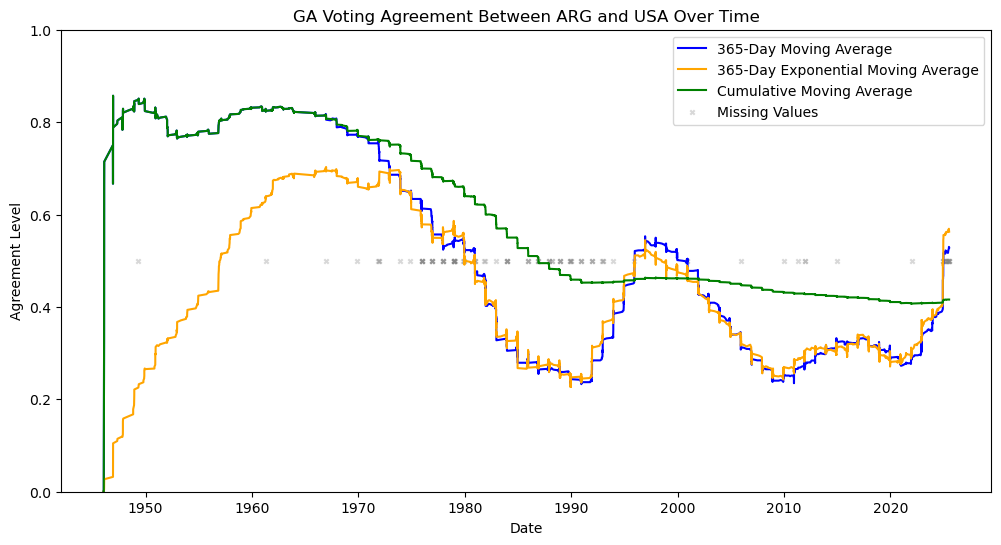

In [10]:
# Matplotlib version

import matplotlib.pyplot as plt

countries = ['ARG', 'USA']
time_span = 365 # days
start_date = None
end_date = None

def moving_average(df, countries, time_span=365, start_date=None, end_date=None):
    """Calculate moving average of agreement between two countries over time."""

    df_ma = df[["undl_id", "date"] + countries].copy()

    def calc_agreement(row, countries): # Current version only supports 2 countries
        # Map vote values to numeric values for calculation
        vote_mapping = {"Y": 1, "A": 0, "N": -1}
        
        # Check if both countries have valid votes
        if row[countries[0]] in vote_mapping and row[countries[1]] in vote_mapping:
            # Calculate the absolute difference between votes
            diff = abs(vote_mapping[row[countries[0]]] - vote_mapping[row[countries[1]]])
            # Calculate agreement value (1 - diff/2)
            # Max difference is 2, so we divide by 2 to normalize to [0,1]
            agreement = 1 - (diff / 2)
            return agreement
        else:
            # Return NaN if either country didn't vote or had an invalid vote
            return float('nan')

    # Calculate agreement
    df_ma['agreement'] = df_ma.apply(lambda row: calc_agreement(row, countries), axis=1)
    df_ma['date'] = pd.to_datetime(df_ma['date'])
    df_ma = df_ma.sort_values('date')

    # Filter for start_date and end_date
    if start_date:
        df_ma = df_ma[df_ma['date'] >= pd.to_datetime(start_date)]
    if end_date:
        df_ma = df_ma[df_ma['date'] <= pd.to_datetime(end_date)]

    # Fill out missing values
    # df_ma = df_ma.fillna(method='ffill') # We need to figure out what to do with missing values

    # Calculate moving averages
    df_ma['agreement_sma'] = df_ma['agreement'].rolling(window=time_span, min_periods=1).mean()
    df_ma['agreement_ema'] = df_ma['agreement'].ewm(span=time_span, adjust=False).mean()
    df_ma['agreement_cma'] = df_ma['agreement'].expanding(min_periods=1).mean()
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df_ma['date'], df_ma['agreement_sma'], label=f'{time_span}-Day Moving Average', color='blue')
    plt.plot(df_ma['date'], df_ma['agreement_ema'], label=f'{time_span}-Day Exponential Moving Average', color='orange')
    plt.plot(df_ma['date'], df_ma['agreement_cma'], label=f'Cumulative Moving Average', color='green')
    
    # # Add scatter plot for daily agreement values
    # # Use masked array to avoid plotting NaN values with red dots
    # #mask = ~pd.isna(df_ma['agreement'])
    # #plt.scatter(df_ma['date'][mask], df_ma['agreement'][mask], label='Daily Agreement', color='red', alpha=0.3, s=10)
    
    # # Mark missing values with a different symbol and color
    mask_na = pd.isna(df_ma['agreement'])
    if mask_na.any():
        plt.scatter(df_ma['date'][mask_na], [0.5] * mask_na.sum(), label='Missing Values', 
                   color='gray', marker='x', alpha=0.3, s=10)
        
    
    plt.xlabel('Date')
    plt.ylabel('Agreement Level')
    plt.title(f'GA Voting Agreement Between {countries[0]} and {countries[1]} Over Time')
    plt.ylim(0, 1)
    plt.legend()
    plt.show()

moving_average(df_ga_transformed, countries, time_span=time_span, start_date=start_date, end_date=end_date)

In [ ]:
# Plotly version
import plotly.graph_objects as go

countries = ['ARG', 'USA']
time_span = 365 # days
start_date = None
end_date = None

def moving_average(df, countries, time_span=365, start_date=None, end_date=None):
    """Calculate moving average of agreement between two countries over time."""

    df_ma = df[["undl_id", "date"] + countries].copy()

    def calc_agreement(row, countries): # Current version only supports 2 countries
        # Map vote values to numeric values for calculation
        vote_mapping = {"Y": 1, "A": 0, "N": -1}
        
        # Check if both countries have valid votes
        if row[countries[0]] in vote_mapping and row[countries[1]] in vote_mapping:
            # Calculate the absolute difference between votes
            diff = abs(vote_mapping[row[countries[0]]] - vote_mapping[row[countries[1]]])
            # Calculate agreement value (1 - diff/2)
            # Max difference is 2, so we divide by 2 to normalize to [0,1]
            agreement = 1 - (diff / 2)
            return agreement
        else:
            # Return NaN if either country didn't vote or had an invalid vote
            return float('nan')

    # Calculate agreement
    df_ma['agreement'] = df_ma.apply(lambda row: calc_agreement(row, countries), axis=1)
    df_ma['date'] = pd.to_datetime(df_ma['date'])
    df_ma = df_ma.sort_values('date')

    # Filter for start_date and end_date
    if start_date:
        df_ma = df_ma[df_ma['date'] >= pd.to_datetime(start_date)]
    if end_date:
        df_ma = df_ma[df_ma['date'] <= pd.to_datetime(end_date)]

    # Fill out missing values
    # df_ma = df_ma.fillna(method='ffill') # We need to figure out what to do with missing values

    # Calculate moving averages
    df_ma['agreement_sma'] = df_ma['agreement'].rolling(window=time_span, min_periods=1).mean()
    df_ma['agreement_ema'] = df_ma['agreement'].ewm(span=time_span, adjust=False).mean()
    df_ma['agreement_cma'] = df_ma['agreement'].expanding(min_periods=1).mean()

    mask_na = pd.isna(df_ma['agreement'])
    # Create figure
    fig = go.Figure()

    # Add traces for the different moving averages
    fig.add_trace(
        go.Scatter(
            x=df_ma['date'], 
            y=df_ma['agreement_sma'], 
            mode='lines', 
            name=f'{time_span}-Day Moving Average',
            line=dict(color='blue')
        )
    )

    fig.add_trace(
        go.Scatter(
            x=df_ma['date'], 
            y=df_ma['agreement_ema'], 
            mode='lines', 
            name=f'{time_span}-Day Exponential Moving Average',
            line=dict(color='orange')
        )
    )

    fig.add_trace(
        go.Scatter(
            x=df_ma['date'], 
            y=df_ma['agreement_cma'], 
            mode='lines', 
            name='Cumulative Moving Average',
            line=dict(color='green')
        )
    )

    # Add scatter points for missing values if any exist
    if mask_na.any():
        fig.add_trace(
            go.Scatter(
                x=df_ma['date'][mask_na], 
                y=[0.5] * mask_na.sum(), 
                mode='markers', 
                name='Missing Values',
                marker=dict(color='gray', symbol='x', size=8),
                opacity=0.3
            )
        )

    # Update layout
    fig.update_layout(
        title=f'GA Voting Agreement Between {countries[0]} and {countries[1]} Over Time',
        xaxis_title='Date',
        yaxis_title='Agreement Level',
        yaxis=dict(range=[0, 1]),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        template="plotly_white",
        hovermode="x unified"
    )

    # Show figure
    fig.show()

moving_average(df_ga_transformed, countries, time_span=time_span, start_date=start_date, end_date=end_date)

# UNBIS Thesaurus and session topics analysis

TODO:
1. Parse the subjects reasonably
2. Check how many subjects are in the thesaurus
3. Check for the ones that are not if it's a parsing issue or if it is actually something different

In [2]:
import pandas as pd


df_ga = pd.read_csv("C:\\Users\\janic\\OneDrive\\Desktop\\ETH\\UN Projekt\\data\\2025_7_23_ga_voting.csv")
df_thesaurus = pd.read_csv("C:\\Users\\janic\\OneDrive\\Desktop\\ETH\\UN Projekt\\data\\unbist-20250708.csv")

C:\Users\janic\AppData\Local\Temp\ipykernel_11532\2097752669.py:4: DtypeWarning: Columns (5,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ga = pd.read_csv("C:\\Users\\janic\\OneDrive\\Desktop\\ETH\\UN Projekt\\data\\2025_7_23_ga_voting.csv")


## Parsing subjects

Some subjects have the form "{Topic}--{Subtopic/Detail}".
Some subjects have the form "{Topic}|{Topic}", in this case I assume that this is how multiple subjects are encoded.

So current plan: Split for "|" first, then split for "--" and take the first part.

In [17]:
# Parsing subjects

print("Total unique unprocessed subjects in GA data: ", len(df_ga['subjects'].unique()))
print(df_ga['subjects'].unique()[:5]) # Print first 5 unique subjects



Total unique unprocessed subjects in GA data:  437
['NON-NUCLEAR-WEAPON STATES' 'NUCLEAR WEAPON TESTS--TREATIES'
 'DISARMAMENT--GENERAL AND COMPLETE' 'NAMIBIA QUESTION'
 'DECOLONIZATION--UN SYSTEM|UN. ECONOMIC AND SOCIAL COUNCIL--REPORTS']


In [18]:
temp_subjects = df_ga['subjects'].str.split('|').explode()
print("Total unique subjects after splitting at '|': ", len(temp_subjects.unique()))
print(temp_subjects.unique()[:5]) # Print first 5 unique subjects after splitting


Total unique subjects after splitting at '|':  397
['NON-NUCLEAR-WEAPON STATES' 'NUCLEAR WEAPON TESTS--TREATIES'
 'DISARMAMENT--GENERAL AND COMPLETE' 'NAMIBIA QUESTION'
 'DECOLONIZATION--UN SYSTEM']


In [ ]:
subjects = temp_subjects.str.split('--').str[0].str.strip().unique()
print("Total unique subjects after further splitting at '--': ", len(subjects))
print(subjects[:5])


Total unique subjects after further splitting at '--' and cleaning:  249
['NON-NUCLEAR-WEAPON STATES' 'NUCLEAR WEAPON TESTS' 'DISARMAMENT'
 'NAMIBIA QUESTION' 'DECOLONIZATION']


In [21]:
# Maybe interesting to see what the second part after the "--" is, maybe it is relevant
subject_suffix = temp_subjects.str.split('--').str[1].str.strip()
print("Total unique second parts after splitting at '--': ", len(subject_suffix.unique()))
print(subject_suffix.unique()[:5]) # Print first 5 unique second parts after splitting

Total unique second parts after splitting at '--':  163
[nan 'TREATIES' 'GENERAL AND COMPLETE' 'UN SYSTEM' 'REPORTS']


## Checking subjects for thesaurus matches

Now we check how many of the parsed subjects are in the thesaurus

In [24]:
# get thesaurus labels
thesaurus_labels = df_thesaurus['prefLabel'].unique()

print(thesaurus_labels[:10])

['GEOGRAPHY' 'GEOGRAFIA' 'GEOGRAPHIE' 'ГЕОГРАФИЯ' '地理' 'الجغرافيا'
 'رسم الخرائط' 'CARTOGRAPHY' 'CARTOGRAFIA' 'CARTOGRAPHIE']


In [26]:
# Check for the subjects in the thesaurus

# Convert both arrays to sets for faster lookup
ga_subjects_set = set(subjects) - {None}  # Remove None values
thesaurus_labels_set = set(thesaurus_labels)

# Find matches
matches = ga_subjects_set.intersection(thesaurus_labels_set)

# Find subjects not in thesaurus
not_in_thesaurus = ga_subjects_set - thesaurus_labels_set

# Print results
print(f"Total unique GA subjects: {len(ga_subjects_set)}")
print(f"Total unique thesaurus labels: {len(thesaurus_labels_set)}")
print(f"Number of direct matches: {len(matches)}")
print(f"Percentage of GA subjects found in thesaurus: {len(matches)/len(ga_subjects_set)*100:.2f}%")

# Display the first 20 matches
#print("\nSample matches:")
#for match in list(matches)[:20]:
#    print(f"- {match}")

# Display the first 20 non-matches
print("\nSample GA subjects not found in thesaurus:")
for subject in list(not_in_thesaurus)[:20]:
    print(f"- {subject}")

Total unique GA subjects: 249
Total unique thesaurus labels: 42675
Number of direct matches: 176
Percentage of GA subjects found in thesaurus: 70.68%

Sample GA subjects not found in thesaurus:
- UN. SECRETARIAT
- NUCLEAR DISARMAMENT NEGOTIATIONS
- UN INTERIM FORCE IN LEBANON
- UN. GENERAL ASSEMBLY (66TH SESS. : 2011-2012). CREDENTIALS COMMITTEE
- ASSOCIATION OF SOUTHEAST ASIAN NATIONS
- UN CHARTER
- 2030 AGENDA
- PEACE AND SECURITY
- UN SYSTEM
- MILLENNIUM SUMMIT
- UN RESOLUTIONS
- MEDITERRANEAN-DEAD SEA CANAL PROJECT
- UNIFIL
- CENTRAL ASIAN
- COLLECTIVE SECURITY TREATY ORGANIZATION
- KAMPUCHEA SITUATION
- UN. OFFICE OF THE HIGH COMMISSIONER FOR HUMAN RIGHTS
- LIBYAN ARAB JAMAHIRIYA
- PACIFIC ISLANDS FORUM
- COUNCIL OF EUROPE


In [29]:
# Check if some suffixes are in the thesaurus

# Convert both arrays to sets for faster lookup
ga_subjects_suffix_set = set(subject_suffix) - {None}  # Remove None values
thesaurus_labels_set = set(thesaurus_labels)

# Find matches
matches = ga_subjects_suffix_set.intersection(thesaurus_labels_set)

# Find subjects not in thesaurus
not_in_thesaurus = ga_subjects_suffix_set - thesaurus_labels_set

# Print results
print(f"Total unique GA suffixes: {len(ga_subjects_suffix_set)}")
print(f"Total unique thesaurus labels: {len(thesaurus_labels_set)}")
print(f"Number of direct matches: {len(matches)}")
print(f"Percentage of GA suffixes found in thesaurus: {len(matches)/len(ga_subjects_suffix_set)*100:.2f}%")

# Display the first 20 matches
print("\nSample matches:")
for match in list(matches)[:20]:
    print(f"- {match}")

# Display the first 20 non-matches
print("\nSample GA suffixes not found in thesaurus:")
for subject in list(not_in_thesaurus)[:20]:
    print(f"- {subject}")

Total unique GA suffixes: 163
Total unique thesaurus labels: 42675
Number of direct matches: 79
Percentage of GA suffixes found in thesaurus: 48.47%

Sample matches:
- PENSIONS
- PRINCIPLES
- LAWS AND REGULATIONS
- OBSERVER STATUS
- FOREIGN INTERESTS
- OLYMPIC GAMES
- INTERNATIONAL RELATIONS
- INTERDEPENDENCE
- ACTIVITIES
- DEMOCRATIC REPUBLIC OF THE CONGO
- HUMAN RIGHTS
- UKRAINE
- ADMINISTRATION
- NUCLEAR-WEAPON-FREE ZONES
- BUDGET CONTRIBUTIONS
- LEBANON
- MYANMAR
- DISARMAMENT
- INTERNATIONAL SECURITY
- FAMILY REUNIFICATION

Sample GA suffixes not found in thesaurus:
- UN. GENERAL ASSEMBLY (4TH SPECIAL SESS. ON DISARMAMENT : xxxx)
- MEDITERRANEAN-DEAD SEA CANAL PROJECT
- DECLARATIONS (1960)
- TREATIES (1966)
- CODE OF CRIMES (DRAFT)
- BUDGET (2010-2011)
- COMPREHENSIVE SYSTEM
- ECONOMIC INTERESTS
- ADVANCEMENT
- PEACEFUL USES
- DECLARATIONS (1970)
- UN. GENERAL ASSEMBLY (15TH SPECIAL SESS. : 1988)
- ASSISTANCE
- CESSATION
- REVIEW
- INTERNATIONAL DECADES (1991-2000)
- PROTECTION
- 

Of the primary subjects we have 70% in the thesaurus
Of the suffixes we have 48% in the thesaurus

So maybe we want a combination?

In [ ]:
# Check for how many presplit subjects neither the primary subject nor the suffix is in the thesaurus

# Split subjects by "--" and check all parts
subjects_not_in_thesaurus = []

for subject in temp_subjects:
    if isinstance(subject, str):
        # Split by pipe first to handle multiple subjects
        parts = subject.split('--')
        
        has_atleast_one_part = False

        for part in parts:
            if part.strip() in thesaurus_labels_set:
                has_atleast_one_part = True
                break
        
        if not has_atleast_one_part:
            subjects_not_in_thesaurus.append(subject)

# Remove duplicates
subjects_not_in_thesaurus = list(set(subjects_not_in_thesaurus))

# Display results
print(f"Total subjects where neither primary nor suffix is in thesaurus: {len(subjects_not_in_thesaurus)}")
print(f"Percentage of such subjects: {len(subjects_not_in_thesaurus)/len(temp_subjects.unique())*100:.2f}%")
print("\nSample of subjects not found in thesaurus (first 20):")
for subject in sorted(subjects_not_in_thesaurus)[:20]:
    print(f"- {subject}")

Total subjects where neither primary nor suffix is in thesaurus: 69
Percentage of such subjects: 17.38%

Sample of subjects not found in thesaurus (first 20):
- ARMED CONFLICTS PREVENTION
- ASSOCIATION OF SOUTHEAST ASIAN NATIONS--UN
- AUTONOMOUS WEAPONS
- AZERBAIJAN SITUATION
- CENTRAL ASIAN--UCLEAR-WEAPON-FREE ZONE
- CENTRAL EUROPEAN INITIATIVE--UN
- CHAGOS ARCHIPELAGO--UN. INTERNATIONAL COURT OF JUSTICE OPINION
- CLONING OF HUMAN BEINGS--TREATIES (PROPOSED)
- COLLECTIVE SECURITY
- COLLECTIVE SECURITY TREATY ORGANIZATION--UN
- COUNCIL OF EUROPE--UN
- ECONOMIC COOPERATION ORGANIZATION--UN
- IAEA--REPORTS
- INTERNATIONAL CRIMINAL COURT--REPORTS
- KAMPUCHEA SITUATION
- KOSOVO--UN. INTERNATIONAL COURT OF JUSTICE OPINION
- LEAGUE OF ARAB STATES--UN
- MEDITERRANEAN-DEAD SEA CANAL PROJECT
- MULTILATERAL TREATIES--DRAFTING PROCESS
- NATURE


So if we loosen our matching criteria we end up with ~82% of subjects in the thesaurus.

1. So there are still quite some uncategorized subjects
2. After looking into them, it looks like there has been some variance in the naming. Example : "Cloning of Human beings" has no match, but there is "Human cloning" in the thesaurus.

How do we continue?
1. We could try more advanced matching
2. We could ignore the thesaurus and just use the subjects as they are and use them as grouping criteria
3. We could ignore the subjects that are not included in the thesaurus
4. We could look at other metadata fields (session topics, agenda etc.) for backup categorization -> don't think it will help much
5. Another issue is that we also have quite some resolutions without any subjects
6. Also if we just look at the primary subjects we already have ~250 unique subjects, which are already quite hard to overview? If we take only the thesaurus matches we get ~180. So a grouping of subjects would be helpful.

-> there's a hierarchy in the thesaurus, maybe we can use that one to group subjects? And then make advanced and simple groups available to endusers?

In [15]:
print(df_ga['subjects'].unique())

['NON-NUCLEAR-WEAPON STATES' 'NUCLEAR WEAPON TESTS--TREATIES'
 'DISARMAMENT--GENERAL AND COMPLETE' 'NAMIBIA QUESTION'
 'DECOLONIZATION--UN SYSTEM|UN. ECONOMIC AND SOCIAL COUNCIL--REPORTS'
 'DECOLONIZATION'
 'ORGANIZATION FOR SECURITY AND COOPERATION IN EUROPE--UN'
 'ECONOMIC ASSISTANCE|ECONOMIC ASSISTANCE--DEMOCRATIC REPUBLIC OF THE CONGO'
 'TERRITORIES OCCUPIED BY ISRAEL--SETTLEMENT POLICY' 'UNRWA--ACTIVITIES'
 'HUMAN RIGHTS ADVANCEMENT' 'MIDDLE EAST SITUATION|PALESTINE QUESTION'
 'PALESTINE QUESTION' 'INFORMATION--INTERNATIONAL SECURITY'
 'BALLISTIC MISSILES' 'SOUTHERN HEMISPHERE--NUCLEAR-WEAPON-FREE ZONES'
 'PEACE--CONVENTIONAL DISARMAMENT'
 'CENTRAL ASIAN--UCLEAR-WEAPON-FREE ZONE'
 'TERRITORIES OCCUPIED BY ISRAEL--HUMAN RIGHTS--REPORTS' nan
 'MIDDLE EAST SITUATION' 'NON-NUCLEAR-WEAPON STATES--SECURITY'
 'HUMAN RIGHTS--REPORTS|HUMAN RIGHTS--IRAN (ISLAMIC REPUBLIC OF)'
 'NON-SELF-GOVERNING TERRITORIES--ECONOMIC INTERESTS|DECOLONIZATION'
 'TERRITORIES OCCUPIED BY ISRAEL--NATURAL RESOU

In [3]:
ga_subjects = df_ga['subjects'].str.split('; ').explode().unique()
print(ga_subjects)



['NON-NUCLEAR-WEAPON STATES' 'NUCLEAR WEAPON TESTS--TREATIES'
 'DISARMAMENT--GENERAL AND COMPLETE' 'NAMIBIA QUESTION'
 'DECOLONIZATION--UN SYSTEM|UN. ECONOMIC AND SOCIAL COUNCIL--REPORTS'
 'DECOLONIZATION'
 'ORGANIZATION FOR SECURITY AND COOPERATION IN EUROPE--UN'
 'ECONOMIC ASSISTANCE|ECONOMIC ASSISTANCE--DEMOCRATIC REPUBLIC OF THE CONGO'
 'TERRITORIES OCCUPIED BY ISRAEL--SETTLEMENT POLICY' 'UNRWA--ACTIVITIES'
 'HUMAN RIGHTS ADVANCEMENT' 'MIDDLE EAST SITUATION|PALESTINE QUESTION'
 'PALESTINE QUESTION' 'INFORMATION--INTERNATIONAL SECURITY'
 'BALLISTIC MISSILES' 'SOUTHERN HEMISPHERE--NUCLEAR-WEAPON-FREE ZONES'
 'PEACE--CONVENTIONAL DISARMAMENT'
 'CENTRAL ASIAN--UCLEAR-WEAPON-FREE ZONE'
 'TERRITORIES OCCUPIED BY ISRAEL--HUMAN RIGHTS--REPORTS' nan
 'MIDDLE EAST SITUATION' 'NON-NUCLEAR-WEAPON STATES--SECURITY'
 'HUMAN RIGHTS--REPORTS|HUMAN RIGHTS--IRAN (ISLAMIC REPUBLIC OF)'
 'NON-SELF-GOVERNING TERRITORIES--ECONOMIC INTERESTS|DECOLONIZATION'
 'TERRITORIES OCCUPIED BY ISRAEL--NATURAL RESOU

In [4]:
print(df_thesaurus.columns)

Index(['uri', 'prefLabel'], dtype='object')


In [5]:
print(df_thesaurus.head())

                                       uri   prefLabel
0  http://metadata.un.org/thesaurus/030101   GEOGRAPHY
1  http://metadata.un.org/thesaurus/030101   GEOGRAFIA
2  http://metadata.un.org/thesaurus/030101  GEOGRAPHIE
3  http://metadata.un.org/thesaurus/030101   ГЕОГРАФИЯ
4  http://metadata.un.org/thesaurus/030101          地理


In [7]:
thesaurus_labels = df_thesaurus['prefLabel'].unique()

print(thesaurus_labels)

['GEOGRAPHY' 'GEOGRAFIA' 'GEOGRAPHIE' ... 'الإختصاص القضائي العالمي'
 'COMPETENCE UNIVERSELLE' 'JURISDICCIÓN UNIVERSAL']


In [8]:
print(len(thesaurus_labels))

42675


In [9]:
# Convert both arrays to sets for faster lookup
ga_subjects_set = set(ga_subjects) - {None}  # Remove None values
thesaurus_labels_set = set(thesaurus_labels)

# Find matches
matches = ga_subjects_set.intersection(thesaurus_labels_set)

# Find subjects not in thesaurus
not_in_thesaurus = ga_subjects_set - thesaurus_labels_set

# Print results
print(f"Total unique GA subjects: {len(ga_subjects_set)}")
print(f"Total unique thesaurus labels: {len(thesaurus_labels_set)}")
print(f"Number of direct matches: {len(matches)}")
print(f"Percentage of GA subjects found in thesaurus: {len(matches)/len(ga_subjects_set)*100:.2f}%")

# Display the first 20 matches
print("\nSample matches:")
for match in list(matches)[:20]:
    print(f"- {match}")

# Display the first 20 non-matches
print("\nSample GA subjects not found in thesaurus:")
for subject in list(not_in_thesaurus)[:20]:
    print(f"- {subject}")

Total unique GA subjects: 437
Total unique thesaurus labels: 42675
Number of direct matches: 103
Percentage of GA subjects found in thesaurus: 23.57%

Sample matches:
- ANGUILLA QUESTION
- CONVENTIONAL WEAPONS
- FALKLAND ISLANDS (MALVINAS) QUESTION
- MILITARY EXPENDITURES
- PEACEKEEPING OPERATIONS
- SOCIAL CONDITIONS
- COUNTER-TERRORISM
- FALKLAND ISLANDS (MALVINAS)
- SAINT HELENA QUESTION
- DEVELOPMENT FINANCE
- STOCKPILE MANAGEMENT
- BRITISH VIRGIN ISLANDS QUESTION
- HUMAN RIGHTS
- FOOD SECURITY
- DIPLOMATS' SECURITY
- INDUSTRIAL DEVELOPMENT
- NUCLEAR DISARMAMENT
- NUCLEAR-WEAPON-FREE ZONES
- GOOD NEIGHBOURLINESS
- RESPONSIBILITY TO PROTECT

Sample GA subjects not found in thesaurus:
- NUCLEAR DISARMAMENT--DECLARATIONS
- DISARMAMENT--GENERAL AND COMPLETE|LANDMINES--TREATIES
- AFRICA--SUSTAINABLE DEVELOPMENT--PARTNERSHIP
- FORCE IN INTERNATIONAL RELATIONS--REPORTS
- MULTILATERAL TREATIES--DRAFTING PROCESS
- ECONOMIC RIGHTS AND DUTIES OF STATES--CHARTER
- INTERNATIONAL TRIBUNAL--FORMER

In [10]:
# Calculate the percentage of GA subjects found in the thesaurus
ga_subjects_set = set(df_ga['subjects'].str.split('; ').explode().unique()) - {None}
thesaurus_labels_set = set(df_thesaurus['prefLabel'].unique())

# Find matches
matches = ga_subjects_set.intersection(thesaurus_labels_set)

# Calculate percentage
match_percentage = len(matches) / len(ga_subjects_set) * 100

print(f"Total unique GA subjects: {len(ga_subjects_set)}")
print(f"Total matches with thesaurus: {len(matches)}")
print(f"Percentage of GA subjects found in thesaurus: {match_percentage:.2f}%")

# Show top subjects by frequency in the dataset
subject_counts = df_ga['subjects'].str.split('; ').explode().value_counts().reset_index()
subject_counts.columns = ['Subject', 'Count']
subject_counts['In_Thesaurus'] = subject_counts['Subject'].apply(lambda x: 'Yes' if x in thesaurus_labels_set else 'No')

# Display top 20 most common subjects and whether they're in the thesaurus
print("\nTop 20 most common subjects:")
print(subject_counts.head(20))

Total unique GA subjects: 437
Total matches with thesaurus: 103
Percentage of GA subjects found in thesaurus: 23.57%

Top 20 most common subjects:
                                              Subject  Count In_Thesaurus
0                   DISARMAMENT--GENERAL AND COMPLETE  43445           No
1   TERRITORIES OCCUPIED BY ISRAEL--HUMAN RIGHTS--...  37489           No
2                                   UNRWA--ACTIVITIES  36586           No
3                                  PALESTINE QUESTION  30835          Yes
4                            HUMAN RIGHTS ADVANCEMENT  19297          Yes
5                                      DECOLONIZATION  18961          Yes
6                               MIDDLE EAST SITUATION  17436          Yes
7                                           APARTHEID  12022          Yes
8                       SELF-DETERMINATION OF PEOPLES  11303          Yes
9            UN. ECONOMIC AND SOCIAL COUNCIL--REPORTS  10963           No
10  DISARMAMENT--UN. GENERAL ASSEMBLY (

In [11]:
# Check if "disarmament" is in the thesaurus
disarmament_in_thesaurus = "DISARMAMENT" in thesaurus_labels_set
print(f"Is 'DISARMAMENT' in the thesaurus? {disarmament_in_thesaurus}")

# Search for all thesaurus terms containing "disarmament" (case-insensitive)
disarmament_related = [term for term in thesaurus_labels if "disarmament" in term.lower()]
print(f"\nThesaurus terms containing 'disarmament' ({len(disarmament_related)} terms):")
for term in sorted(disarmament_related):
    print(f"- {term}")

# Now check how many UN subjects contain "disarmament" but aren't in the thesaurus
disarmament_subjects = [subject for subject in ga_subjects if isinstance(subject, str) and "disarmament" in subject.lower()]
disarmament_subjects_not_in_thesaurus = [subject for subject in disarmament_subjects if subject not in thesaurus_labels_set]

print(f"\nUN subjects containing 'disarmament' but not in the thesaurus ({len(disarmament_subjects_not_in_thesaurus)} terms):")
for subject in sorted(disarmament_subjects_not_in_thesaurus)[:20]:  # Show first 20 only to avoid too much output
    print(f"- {subject}")

if len(disarmament_subjects_not_in_thesaurus) > 20:
    print(f"... and {len(disarmament_subjects_not_in_thesaurus) - 20} more")

Is 'DISARMAMENT' in the thesaurus? True

Thesaurus terms containing 'disarmament' (12 terms):
- CERTIFICATION (DISARMAMENT)
- CONVENTIONAL DISARMAMENT
- DISARMAMENT
- DISARMAMENT AGREEMENTS
- DISARMAMENT AND MILITARY QUESTIONS
- DISARMAMENT EDUCATION
- DISARMAMENT NEGOTIATIONS
- DISARMAMENT RESEARCH
- DISARMAMENT-DEVELOPMENT LINK
- NUCLEAR DISARMAMENT
- REGIONAL DISARMAMENT
- UNILATERAL DISARMAMENT

UN subjects containing 'disarmament' but not in the thesaurus (35 terms):
- ARMS TRANSFERS--TREATIES|DISARMAMENT--GENERAL AND COMPLETE
- DISARMAMENT AGREEMENTS--ENVIRONMENT
- DISARMAMENT AGREEMENTS--OUTER SPACE
- DISARMAMENT--DEVELOPMENT
- DISARMAMENT--GENERAL AND COMPLETE
- DISARMAMENT--GENERAL AND COMPLETE|ARMS TRANSFERS--TRANSPARENCY
- DISARMAMENT--GENERAL AND COMPLETE|ARMS TRANSFERS--TREATIES
- DISARMAMENT--GENERAL AND COMPLETE|BALLISTIC MISSILES
- DISARMAMENT--GENERAL AND COMPLETE|CLUSTER MUNITIONS
- DISARMAMENT--GENERAL AND COMPLETE|LANDMINES--TREATIES
- DISARMAMENT--GENERAL AND COMPL

In [12]:
# First, let's tokenize the subjects by splitting on '--' and taking the first part
tokenized_subjects = []
for subject in ga_subjects:
    if isinstance(subject, str):
        parts = subject.split('--')[0].strip()
        tokenized_subjects.append(parts)
        
# Remove None values and duplicates
tokenized_subjects = [s for s in tokenized_subjects if s]
unique_tokenized_subjects = set(tokenized_subjects)

# Compare with thesaurus labels
tokenized_matches = unique_tokenized_subjects.intersection(thesaurus_labels_set)
not_in_thesaurus_tokenized = unique_tokenized_subjects - thesaurus_labels_set

# Calculate statistics
match_percentage_tokenized = len(tokenized_matches) / len(unique_tokenized_subjects) * 100

# Display results
print(f"Total unique tokenized GA subjects: {len(unique_tokenized_subjects)}")
print(f"Total matches with thesaurus: {len(tokenized_matches)}")
print(f"Percentage of tokenized GA subjects found in thesaurus: {match_percentage_tokenized:.2f}%")

# Show matched subjects
print("\nTop 30 matched tokenized subjects:")
for match in sorted(list(tokenized_matches))[:30]:
    print(f"- {match}")

# Show subjects still not in thesaurus
print("\nTop 30 tokenized subjects not found in thesaurus:")
for subject in sorted(list(not_in_thesaurus_tokenized))[:30]:
    print(f"- {subject}")

# Count occurrences of each tokenized subject
token_counts = {}
for subject in tokenized_subjects:
    token_counts[subject] = token_counts.get(subject, 0) + 1

# Convert to dataframe and sort by count
token_counts_df = pd.DataFrame({'Subject': list(token_counts.keys()), 
                               'Count': list(token_counts.values())})
token_counts_df['In_Thesaurus'] = token_counts_df['Subject'].apply(
    lambda x: 'Yes' if x in thesaurus_labels_set else 'No')
token_counts_df = token_counts_df.sort_values('Count', ascending=False).reset_index(drop=True)

# Display top 20 most common tokenized subjects
print("\nTop 20 most common tokenized subjects:")
print(token_counts_df.head(20))

Total unique tokenized GA subjects: 271
Total matches with thesaurus: 156
Percentage of tokenized GA subjects found in thesaurus: 57.56%

Top 30 matched tokenized subjects:
- AFGHANISTAN SITUATION
- AFRICA
- AMERICAN SAMOA QUESTION
- ANGOLA
- ANGUILLA QUESTION
- ANTARCTICA
- ANTI-MISSILE MISSILES
- APARTHEID
- ARMS RACE
- ARMS TRANSFERS
- BALLISTIC MISSILES
- BERMUDA QUESTION
- BOSNIA AND HERZEGOVINA SITUATION
- BRITISH VIRGIN ISLANDS QUESTION
- CAYMAN ISLANDS QUESTION
- CENTRAL AMERICA SITUATION
- CENTRAL ASIA
- CHEMICAL AND BIOLOGICAL WARFARE
- CHEMICAL WEAPONS
- CLIMATE
- CLUSTER MUNITIONS
- COLONIAL COUNTRIES
- COMMODITIES
- COMORIAN ISLAND OF MAYOTTE
- CONFERENCE AND MEETING SERVICES
- CONVENTIONAL WEAPONS
- COORDINATION WITHIN UN SYSTEM
- COUNTER-TERRORISM
- CRIME PREVENTION
- CROATIA

Top 30 tokenized subjects not found in thesaurus:
- 2030 AGENDA
- AGENDA 21
- ARMED CONFLICTS PREVENTION
- ASSOCIATION OF SOUTHEAST ASIAN NATIONS
- AUTONOMOUS WEAPONS
- AZERBAIJAN SITUATION
- CENTR